## Round 2 of model fitting and selection
## Pick the features highlighted in round1
## Check a few strategies

In [1]:
 !pip install fastparquet

In [2]:
!pip install -U imbalanced-learn

In [3]:
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

In [4]:
import pandas as pd
import numpy as np
import os as os
import datetime   

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

pd.set_option('display.max_rows', 500)

import seaborn as sns
import matplotlib as plt

datadir = '/challenge/seeing-through-the-fog/data/train_data'

In [5]:
## Read in df_tar
df_tar = pd.read_parquet(datadir + "/" + "target.parquet")


## Read in inner and outer merge training data master tables
master_inner_join = '/home/huangz36/test_process/master_table_inner_merge.txt'
master_outer_join = '/home/huangz36/test_process/master_table_outer_merge.txt'

df_inner = pd.read_csv(master_inner_join, sep='\t', header=0)
df_outer = pd.read_csv(master_outer_join, sep='\t', header=0)

df_inner_tar = df_tar.merge(df_inner, how='inner', on='patientid')
df_outer_tar = df_tar.merge(df_outer, how='inner', on='patientid')

print("inner shape", df_inner_tar.shape)
print("outer shape", df_outer_tar.shape)

/tmp/ipykernel_13829/1833123714.py:9: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inner = pd.read_csv(master_inner_join, sep='\t', header=0)
/tmp/ipykernel_13829/1833123714.py:10: DtypeWarning: Columns (49,50,51,52,53,54,55,56,57,58,59,71,72,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  df_outer = pd.read_csv(master_outer_join, sep='\t', header=0)


inner shape (22709, 95)
outer shape (395364, 95)


## Train with inner joined (the fraction of samples where each sub-table provides information)

In [6]:
df_inner_tar.describe()

,has_long_covid_diag,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,ICD10_status_G,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
count,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,...,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.000000,22709.0
mean,0.004536,8.396803,49.701616,0.030517,0.105993,0.070325,0.207671,0.614426,0.329869,0.310670,...,0.142102,0.000925,0.077943,0.004404,0.006649,0.073099,0.000484,0.005416,0.013827,0.0
std,0.067196,10.137289,12.293946,0.172007,0.307836,0.255699,0.405649,0.486741,0.470176,0.462778,...,0.349163,0.030396,0.268087,0.066214,0.081274,0.260304,0.022004,0.073398,0.116776,0.0
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,2.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,4.000000,54.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,11.000000,59.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,61.000000,61.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [7]:
df_inner_tar['has_long_covid_diag'].value_counts()

0    22606
1      103
Name: has_long_covid_diag, dtype: int64

In [8]:
df_inner_tar[df_inner_tar['has_long_covid_diag']==1].shape[0]

fraction_of_positives = df_inner_tar[df_inner_tar['has_long_covid_diag']==1].shape[0] / df_inner_tar.shape[0]
print(fraction_of_positives)

0.004535646659914572


In [9]:
df_inner_tar.head()

,patientid,has_long_covid_diag,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
0,RAADC3-466698,0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,RAADC3-473360,0,5.0,48.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,RAADC3-434882,0,7.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,RAADC3-310560,0,38.0,59.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,RAADC3-634186,0,9.0,43.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [10]:
df_inner_tar.columns

Index(['patientid', 'has_long_covid_diag', 'earliest_to_covid_diag',
       'latest_to_covid_diag', 'ICD10_status_A', 'ICD10_status_B',
       'ICD10_status_C', 'ICD10_status_D', 'ICD10_status_E', 'ICD10_status_F',
       'ICD10_status_G', 'ICD10_status_H', 'ICD10_status_I', 'ICD10_status_J',
       'ICD10_status_K', 'ICD10_status_L', 'ICD10_status_M', 'ICD10_status_N',
       'ICD10_status_O', 'ICD10_status_P', 'ICD10_status_Q', 'ICD10_status_R',
       'ICD10_status_S', 'ICD10_status_T', 'ICD10_status_U', 'ICD10_status_V',
       'ICD10_status_W', 'ICD10_status_X', 'ICD10_status_Y', 'ICD10_status_Z',
       'Drug_count_Antibiotic', 'Drug_count_Anxiety', 'Drug_count_Cholesterol',
       'Drug_count_Cough', 'Drug_count_Diabetes', 'Drug_count_Immune',
       'Drug_count_Infection', 'Drug_count_Muscle', 'Drug_count_Nutrition',
       'Drug_count_Skin', 'Drug_count_breath', 'Drug_count_diabetes',
       'Drug_count_fever_pain', 'Drug_count_heart_blood', 'Drug_count_hormone',
       'Drug_

In [11]:
df_inner_tar[['birth_yr', 'index_month_year', 'index_month_year_from_begin', 'after_long_covid_start', 'age']]

,birth_yr,index_month_year,index_month_year_from_begin,after_long_covid_start,age
0,1973,2021-10-01,639,1,48
1,1988,2020-12-01,335,0,33
2,1995,2020-10-01,274,0,26
3,1967,2021-11-01,670,1,54
4,1955,2020-11-01,305,0,66
...,...,...,...,...,...
22704,1932 and Earlier,2021-02-01,397,0,89
22705,1989,2021-04-01,456,0,32
22706,1956,2020-11-01,305,0,65
22707,1947,2020-11-01,305,0,74


## Separate into "data" and "target", where duplicated features have been dropped
### Drop birth_yr (age covered the info with continous int), drop index_month_year (index_month_year_from_begin contains continous int)

In [12]:
## Drop redundant columns in date or year formats
data = df_inner_tar.drop(columns=["has_long_covid_diag", "birth_yr", "index_month_year"])
target = df_inner_tar["has_long_covid_diag"]


## Replace the non-numrical values with NaN in the following columns
data['Baso_max'] = pd.to_numeric(data['Baso_max'], errors = 'coerce')
data['Lympho_max'] = pd.to_numeric(data['Lympho_max'], errors = 'coerce')
data['Creatinine_max'] = pd.to_numeric(data['Creatinine_max'], errors = 'coerce')
data['WBC_max'] = pd.to_numeric(data['WBC_max'], errors = 'coerce')
data['Glucose_max'] = pd.to_numeric(data['Glucose_max'], errors = 'coerce')
data['CO2_max'] = pd.to_numeric(data['CO2_max'], errors = 'coerce')
data['Mono_max'] = pd.to_numeric(data['Mono_max'], errors = 'coerce')
data['PLT_max'] = pd.to_numeric(data['PLT_max'], errors = 'coerce')
data['Eosin_max'] = pd.to_numeric(data['Eosin_max'], errors = 'coerce')
data['Neutro_max'] = pd.to_numeric(data['Neutro_max'], errors = 'coerce')
data['RBC_max'] = pd.to_numeric(data['RBC_max'], errors = 'coerce')

In [13]:
## list of non-numeric columns, and numeric columns

non_num_features = ['SMOKE', 'ALCOHOL', 'gender', 'race', 'ethnicity', 'COVID-19', 'Influenza']

num_features = ['earliest_to_covid_diag', 'latest_to_covid_diag',\
               'ICD10_status_A', 'ICD10_status_B', 'ICD10_status_C', 'ICD10_status_D',
       'ICD10_status_E', 'ICD10_status_F', 'ICD10_status_G', 'ICD10_status_H',
       'ICD10_status_I', 'ICD10_status_J', 'ICD10_status_K', 'ICD10_status_L',
       'ICD10_status_M', 'ICD10_status_N', 'ICD10_status_O', 'ICD10_status_P',
       'ICD10_status_Q', 'ICD10_status_R', 'ICD10_status_S', 'ICD10_status_T',
       'ICD10_status_U', 'ICD10_status_V', 'ICD10_status_W', 'ICD10_status_X',
       'ICD10_status_Y', 'ICD10_status_Z', 'Drug_count_Antibiotic',
       'Drug_count_Anxiety', 'Drug_count_Cholesterol', 'Drug_count_Cough',
       'Drug_count_Diabetes', 'Drug_count_Immune', 'Drug_count_Infection',
       'Drug_count_Muscle', 'Drug_count_Nutrition', 'Drug_count_Skin',
       'Drug_count_breath', 'Drug_count_diabetes', 'Drug_count_fever_pain',
       'Drug_count_heart_blood', 'Drug_count_hormone',
       'Drug_count_nausea_vomit', 'Drug_count_others', 'Drug_count_seizure',
       'Drug_count_stomach', 'OxSatu_min', 'Glucose_max', 'Creatinine_max',
       'WBC_max', 'RBC_max', 'PLT_max', 'CO2_max', 'Neutro_max', 'Lympho_max',
       'Mono_max', 'Eosin_max', 'Baso_max', 'BMI_max', 'HT_max', 'WT_max',
       'PULSE_max', 'TEMP_max', 'RESP_max', 'HR_max', 'PAIN_max',
       'PACKYRS_max', 'DBP_max', 'SBP_max','index_month_year_from_begin', 'after_long_covid_start',\
               'age','Pertussis', 'Diphtheria', 'Haemophilus B',\
               'Pneumococcal', 'MMR', 'HPV', 'VZV', 'Rabies', 'HEP A', 'HEP B','Palio']


## Separate into cat and numerical, perform further treatments
data_categorical = data[non_num_features]
data_numerical = data[num_features]

## Categorical data columns, one hot encoder
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
data_encoded = encoder.fit_transform(data_categorical)

columns_encoded = encoder.get_feature_names_out(data_categorical.columns)
data_cat_encoded = pd.DataFrame(data_encoded, columns=columns_encoded)

## Numerical data columns, fill NA with median, standard scaler
data_numerical = data[num_features]
data_numerical_imputed = SimpleImputer(missing_values = np.nan, strategy = 'median').fit_transform(data_numerical)
num_columns_imputated = data_numerical.columns

### Imputed only
data_numerical_imputed = pd.DataFrame(data_numerical_imputed, columns=num_columns_imputated)


scaler = StandardScaler()

### Imputed and scaled
data_scaled = scaler.fit_transform(data_numerical_imputed)
data_scaled = pd.DataFrame(data_scaled,
                                 columns=data_numerical_imputed.columns)

In [14]:
data_cat_encoded.head(5)

,SMOKE_Current smoker,SMOKE_Never smoked,SMOKE_Not currently smoking,SMOKE_Other smoking status,SMOKE_Previously smoked,SMOKE_Unknown smoking status,SMOKE_nan,ALCOHOL_Consumes alcohol,ALCOHOL_Does not consume alcohol,ALCOHOL_HASBLED 1. Consumes 8 or more drinks per week,...,"COVID-19_MODERNA,Unspecified",COVID-19_NOVAVAX,COVID-19_PFIZER,COVID-19_Unspecified,"COVID-19_Unspecified,JNJ","COVID-19_Unspecified,PFIZER",COVID-19_nan,Influenza_Inactivated,Influenza_Live,Influenza_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [15]:
data_numerical_imputed.head()

,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,ICD10_status_G,ICD10_status_H,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,48.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.0,59.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,9.0,43.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data_scaled.head()

,earliest_to_covid_diag,latest_to_covid_diag,ICD10_status_A,ICD10_status_B,ICD10_status_C,ICD10_status_D,ICD10_status_E,ICD10_status_F,ICD10_status_G,ICD10_status_H,...,Diphtheria,Haemophilus B,Pneumococcal,MMR,HPV,VZV,Rabies,HEP A,HEP B,Palio
0,-0.729679,-0.870498,-0.177418,-0.344325,-0.275035,-0.511959,-1.262353,1.425309,1.489581,-0.365795,...,-0.406989,-0.030424,-0.290743,-0.066506,-0.081816,-0.280827,-0.022014,-0.073796,-0.11841,0.0
1,-0.335087,-0.138414,-0.177418,-0.344325,-0.275035,-0.511959,0.792171,-0.701602,-0.671330,-0.365795,...,2.457069,-0.030424,-0.290743,-0.066506,-0.081816,-0.280827,-0.022014,-0.073796,-0.11841,0.0
2,-0.137792,-2.985406,-0.177418,-0.344325,-0.275035,-0.511959,-1.262353,-0.701602,-0.671330,-0.365795,...,2.457069,-0.030424,-0.290743,-0.066506,-0.081816,-0.280827,-0.022014,-0.073796,-0.11841,0.0
3,2.920292,0.756355,-0.177418,-0.344325,-0.275035,-0.511959,0.792171,-0.701602,1.489581,-0.365795,...,-0.406989,-0.030424,-0.290743,-0.066506,-0.081816,3.560916,-0.022014,-0.073796,-0.11841,0.0
4,0.059504,-0.545127,-0.177418,-0.344325,-0.275035,1.953282,-1.262353,-0.701602,-0.671330,-0.365795,...,-0.406989,-0.030424,3.439468,-0.066506,-0.081816,-0.280827,-0.022014,-0.073796,-0.11841,0.0


In [17]:
print(data_numerical.shape)
print(data_numerical_imputed.shape)
print(data_scaled.shape)

(22709, 84)
(22709, 84)
(22709, 84)


In [18]:
## Make two versions of the concated data

## Version 1, one-hot encoder + imputed
data_processed_imputed = pd.concat([data_numerical_imputed, data_cat_encoded], axis=1)

## Version 2, one-hot encoder + imputed/scaled
data_processed_imputed_scaled = pd.concat([data_scaled, data_cat_encoded], axis=1)

## Feature importance with inner joined tables

In [19]:
## Train/test split for both versions

data_train_im, data_test_im, target_train_im, target_test_im = train_test_split(
    data_processed_imputed, target, test_size=0.3, random_state=42)

data_train_sc, data_test_sc, target_train_sc, target_test_sc = train_test_split(
    data_processed_imputed_scaled, target, test_size=0.3, random_state=42)

In [22]:
## Feature importance ranking, using random forest model, use imputed only
rf_final_model_im = RandomForestClassifier(max_features= 'auto', n_estimators=200,\
                                        oob_score = True, max_depth=None, min_samples_split=50,\
                                        min_samples_leaf = 500, bootstrap=True,criterion='gini') 

rf_final_model_sc = RandomForestClassifier(max_features= 'auto', n_estimators=200,\
                                        oob_score = True, max_depth=None, min_samples_split=50,\
                                        min_samples_leaf = 500, bootstrap=True,criterion='gini') 

rf_final_model_im.fit(data_train_im, target_train_im)
y_pred_im = rf_final_model_im.predict(data_test_im)

rf_final_model_sc.fit(data_train_sc, target_train_sc)
y_pred_sc = rf_final_model_sc.predict(data_test_sc)

print(data_train_im.shape, data_test_im.shape, target_train_im.shape, target_test_im.shape)
print(data_train_sc.shape, data_test_sc.shape, target_train_sc.shape, target_test_sc.shape)

test_score_im = rf_final_model_im.score(data_test_im, target_test_im)
print(f"Accuracy of the RF_final_im: {test_score_im:.5f}")

test_score_sc = rf_final_model_sc.score(data_test_im, target_test_im)
print(f"Accuracy of the RF_final_sc: {test_score_sc:.5f}")

print("Accuracy of imputed model :",metrics.accuracy_score(target_test_im, y_pred_im))
print("Accuracy of imputed and scaled model :",metrics.accuracy_score(target_test_sc, y_pred_sc))

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


(15896, 123) (6813, 123) (15896,) (6813,)
(15896, 123) (6813, 123) (15896,) (6813,)
Accuracy of the RF_final_im: 0.99486
Accuracy of the RF_final_sc: 0.99486
Accuracy of imputed model : 0.9948627623660649
Accuracy of imputed and scaled model : 0.9948627623660649


In [23]:
## Compare y_pred with target_test

target_label = np.array(target_test_im)
predict_label_im = np.array(y_pred_im)
dataset = pd.DataFrame({'target_label': target_label, 'prediction_label': list(predict_label_im)}, \
                       columns=['target_label', 'prediction_label'])
df_confusion = pd.crosstab(target_label, predict_label_im)
df_confusion

col_0,0
row_0,
0,6778
1,35


In [24]:
dataset['target_label'].value_counts()

0    6778
1      35
Name: target_label, dtype: int64

In [25]:
dataset['prediction_label'].value_counts()

0    6813
Name: prediction_label, dtype: int64

In [26]:
dataset.head()

,target_label,prediction_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [27]:
importance_im_list = rf_final_model_im.feature_importances_
importance_im = pd.DataFrame(importance_im_list, index=data_processed_imputed.columns, 
                          columns=["Importance"]).sort_values(['Importance'], ascending = [0]).head(100)

importance_im

,Importance
index_month_year_from_begin,0.348362
after_long_covid_start,0.211706
age,0.035851
WT_max,0.020417
latest_to_covid_diag,0.018201
ICD10_status_J,0.017992
SBP_max,0.017182
DBP_max,0.017117
BMI_max,0.016688
CO2_max,0.015452


In [28]:
importance_sc_list = rf_final_model_sc.feature_importances_
importance_sc = pd.DataFrame(importance_sc_list, index=data_processed_imputed_scaled.columns, 
                          columns=["Importance"]).sort_values(['Importance'], ascending = [0]).head(100)

importance_sc

,Importance
index_month_year_from_begin,0.269848
after_long_covid_start,0.259824
age,0.029130
BMI_max,0.025831
latest_to_covid_diag,0.021831
HT_max,0.019169
SBP_max,0.019112
DBP_max,0.017220
Drug_count_stomach,0.015746
ICD10_status_J,0.015406


In [29]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier()
clf = clf.fit(data_train_im, target_train_im)
impt = clf.feature_importances_

#importance_im = pd.DataFrame(importance_sc_list, index=data_processed_imputed.columns, 
#                          columns=["Importance"]).sort_values(['Importance'], ascending = [0]).head(100)



importance_im = pd.DataFrame(
    {'feature': data_processed_imputed.columns.tolist(),
     'impt': importance_sc_list,
    }).sort_values(['impt'], ascending = [0])

importance_im

,feature,impt
70,index_month_year_from_begin,0.269848
71,after_long_covid_start,0.259824
72,age,0.029130
59,BMI_max,0.025831
1,latest_to_covid_diag,0.021831
60,HT_max,0.019169
69,SBP_max,0.019112
68,DBP_max,0.017220
46,Drug_count_stomach,0.015746
11,ICD10_status_J,0.015406


In [30]:
top_feature = importance_im.sort_values(['impt'],ascending = [0]).head(30)
top_feature

,feature,impt
70,index_month_year_from_begin,0.269848
71,after_long_covid_start,0.259824
72,age,0.029130
59,BMI_max,0.025831
1,latest_to_covid_diag,0.021831
60,HT_max,0.019169
69,SBP_max,0.019112
68,DBP_max,0.017220
46,Drug_count_stomach,0.015746
11,ICD10_status_J,0.015406


In [31]:
## Pairwise heat map to understand and select features better
# Visualize the correlation between top features after feature selection
# Calculate spearman correlation 

impt_feature = data_processed_imputed[top_feature.feature].join(target.to_frame())
spearman = impt_feature.corr(method='spearman')

In [32]:
spearman

,index_month_year_from_begin,after_long_covid_start,age,BMI_max,latest_to_covid_diag,HT_max,SBP_max,DBP_max,Drug_count_stomach,ICD10_status_J,...,Drug_count_breath,Drug_count_others,COVID-19_nan,CO2_max,RESP_max,PLT_max,Drug_count_Anxiety,ICD10_status_G,WBC_max,has_long_covid_diag
index_month_year_from_begin,1.000000,0.663936,-0.025759,-0.003339,0.081885,-0.020544,0.006666,-0.021762,0.013717,0.005853,...,-0.003954,-0.020695,-0.472811,-0.000031,-0.011451,0.010803,-0.009667,0.011411,0.009061,0.091954
after_long_covid_start,0.663936,1.000000,-0.034737,-0.015122,0.052027,-0.031440,-0.017110,-0.048913,0.029813,0.018744,...,0.000644,-0.016318,-0.204591,-0.021658,-0.011117,0.010892,-0.009909,0.007405,0.007017,0.135383
age,-0.025759,-0.034737,1.000000,-0.091106,0.074295,0.029716,0.202949,-0.020384,0.102736,0.051939,...,0.053830,0.166709,-0.066011,0.142334,0.052744,-0.114009,0.007681,0.109705,-0.085024,0.020912
BMI_max,-0.003339,-0.015122,-0.091106,1.000000,0.044414,-0.005841,0.164809,0.186476,0.021122,0.035536,...,0.081699,0.076169,0.040488,-0.008141,0.078474,0.059926,0.062742,0.103014,0.117060,0.006259
latest_to_covid_diag,0.081885,0.052027,0.074295,0.044414,1.000000,-0.033648,0.033372,0.066622,0.115597,0.076024,...,0.096869,0.182091,-0.050169,0.016273,0.080992,0.013916,0.146415,0.129137,0.057065,0.019338
HT_max,-0.020544,-0.031440,0.029716,-0.005841,-0.033648,1.000000,0.070832,0.092899,-0.015179,-0.025679,...,-0.040679,0.041388,0.005172,0.031904,0.010678,-0.094303,-0.047477,0.021294,-0.037730,-0.014782
SBP_max,0.006666,-0.017110,0.202949,0.164809,0.033372,0.070832,1.000000,0.439502,0.001187,0.019125,...,0.027157,0.050639,-0.015754,0.003867,0.071366,0.003597,-0.015579,0.045694,-0.004088,0.007384
DBP_max,-0.021762,-0.048913,-0.020384,0.186476,0.066622,0.092899,0.439502,1.000000,0.138737,0.086596,...,0.089416,0.237756,0.007567,0.041118,0.207276,0.063469,0.127131,0.126618,0.115439,-0.000841
Drug_count_stomach,0.013717,0.029813,0.102736,0.021122,0.115597,-0.015179,0.001187,0.138737,1.000000,0.123865,...,0.174832,0.311762,-0.021151,0.050321,0.159175,0.013684,0.188762,0.154569,0.101699,0.006738
ICD10_status_J,0.005853,0.018744,0.051939,0.035536,0.076024,-0.025679,0.019125,0.086596,0.123865,1.000000,...,0.414829,0.135438,-0.005603,0.058153,0.102752,0.045014,0.107521,0.120219,0.065245,0.014813


/tmp/ipykernel_13829/1356595531.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(spearman, dtype=np.bool)


<AxesSubplot:>

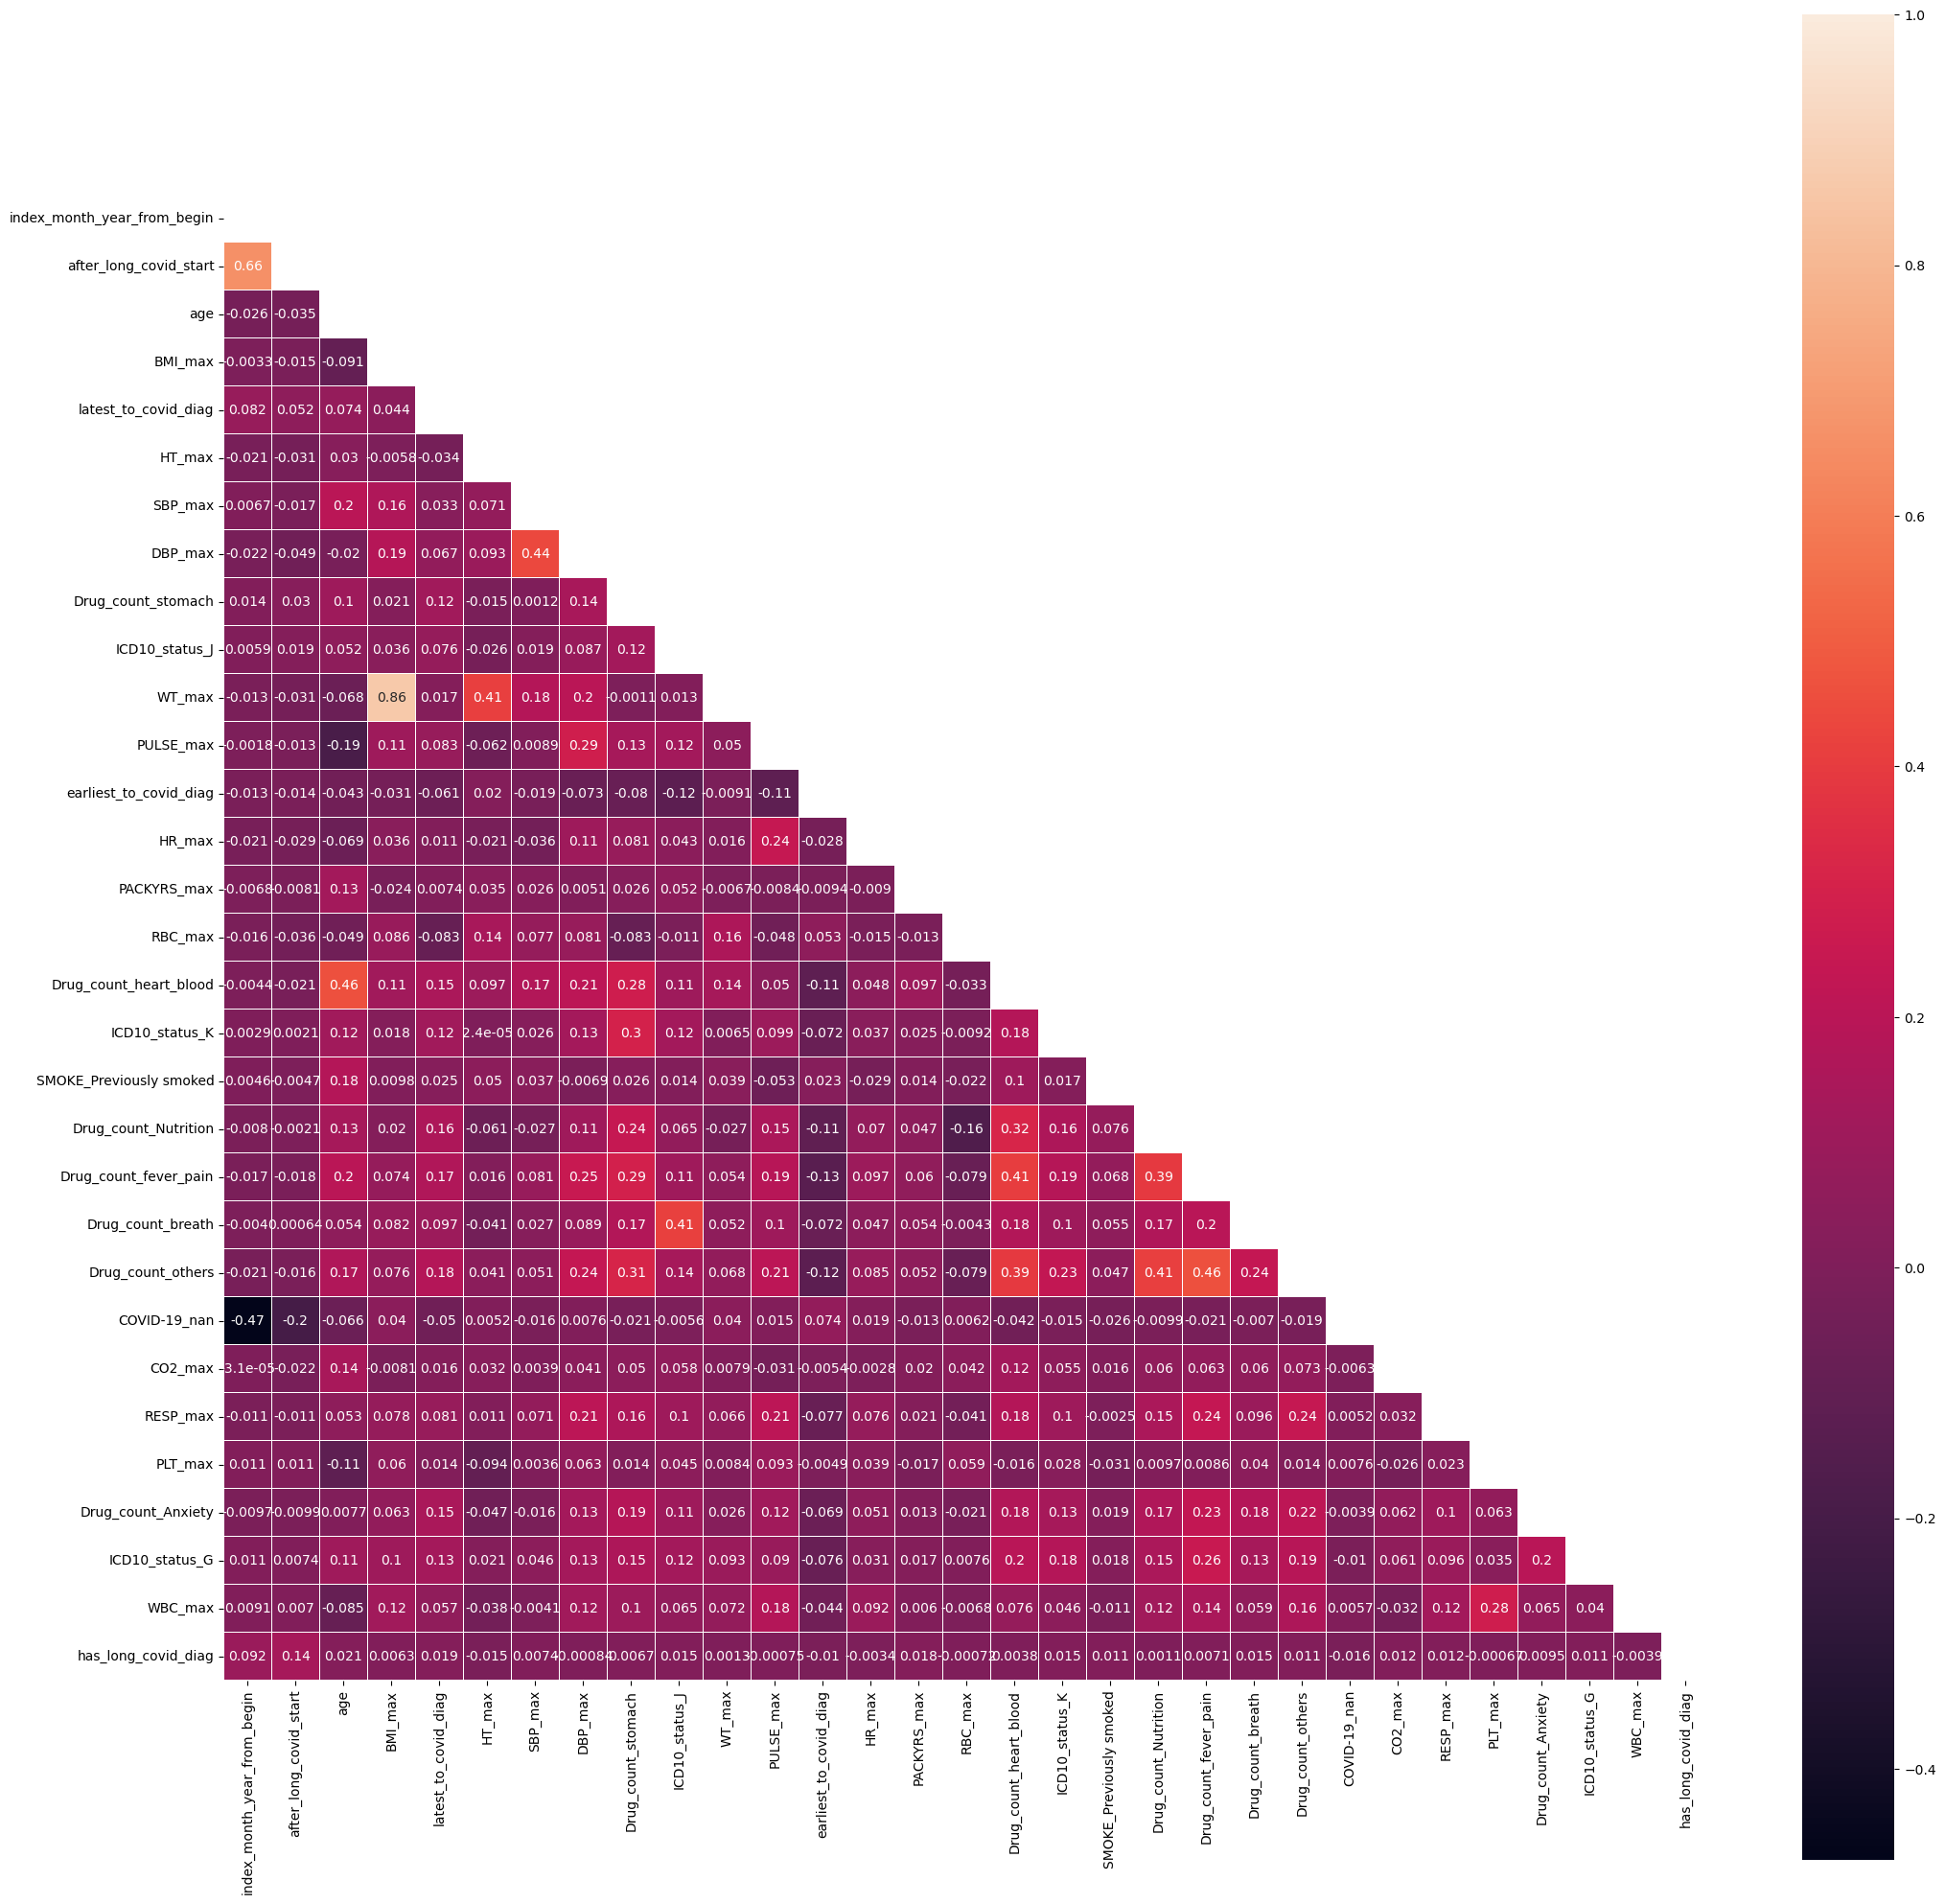

In [33]:
# Visualize the spearman correlation matrix

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# The correlation matrix spearman computed
# Generate a mask for the upper triangle
mask = np.zeros_like(spearman, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.heatmap(spearman, mask = mask, vmax=.8, square=True)

sns.heatmap(spearman, vmin=spearman.values.min(), mask = mask, vmax=1, square=True, 
        linewidths=0.1, annot=True, annot_kws={"size":10})


In [34]:
### Understand the variables with high spearman correlation
#### index_month_year_from_begin vs after_long_covid_start: 0.66
#### Drug_count_heart_blood vs age 0.46
#### WT_max vs BMI_max 0.86
#### HT_max vs WT_max 0.41
#### DBP_max vs SBP_max 0.44
#### Drug_count_breaht vs ICK10_status_I 0.41
#### Drug_count_others vs Drug_count_stomach
#### Drug_count_heart_blood / Drug_count_Nutrition/Drug_count_fever_pain/Drug_count_nausea_vomit vs Drug_count_others
#### Drug_count_Nutrition vs Drug_count_heart_blood
#### Drug_count_fever_pain vs Drug_count_heart_blood
#### Drug_count_fever_pain vs Drug_count_Nutrition
#### Drug_count_nausea_vomit vs Drug_count_fever_pain

## The model predicts every label as "0", suffered from imbalanced class issue
## In the inner join table, only 0.45% of patients are long_covid

In [35]:
df_inner_tar[df_inner_tar['has_long_covid_diag']==1].shape[0]

fraction_of_positives = df_inner_tar[df_inner_tar['has_long_covid_diag']==1].shape[0] / df_inner_tar.shape[0]
print(fraction_of_positives)

0.004535646659914572


### Experiment with possible methods to treat the imbalanced class
#### imbalanced-learn
#### - oversampling, undersampling and combination

In [36]:
### https://learn-scikit.oneoffcoder.com/imbalanced-learn.html

In [37]:
## Base model

## Random forest
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

rdf = []
## data_processed_imputed_scaled
for fold, (tr, te) in enumerate(skf.split(data_processed_imputed_scaled, target)):
    X_tr, X_te = data_processed_imputed_scaled.iloc[tr], data_processed_imputed_scaled.iloc[te]
    y_tr, y_te = target.iloc[tr], target.iloc[te]

    #model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
    model = RandomForestClassifier(n_jobs=-1, random_state=37)
    model.fit(X_tr, y_tr)
    y_pr = model.predict_proba(X_te)[:,1]

    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)
    
    dataset = pd.DataFrame({'y_te': y_te, 'y_pr': list(y_pr)}, \
                       columns=['y_te', 'y_pr'])
    TP = dataset[(dataset['y_te']==1) & (dataset['y_pr']==1)].shape[0]
    Positive = dataset[dataset['y_te']==1].shape[0]
    TPR = round(TP/Positive, 4)

    rdf.append({'auc': auc, 'aps': aps, 'TP': TP, 'Positive': Positive, 'TPR':TPR})

rdf = pd.DataFrame(rdf)

rdf[['auc', 'aps', 'TP', 'Positive', 'TPR']].agg(['mean', 'std'])

,auc,aps,TP,Positive,TPR
mean,0.831740,0.034615,0.0,10.300000,0.0
std,0.066635,0.016604,0.0,0.483046,0.0


In [38]:
## Base model

## Logistics Regression
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

rdf = []
## data_processed_imputed_scaled
for fold, (tr, te) in enumerate(skf.split(data_processed_imputed_scaled, target)):
    X_tr, X_te = data_processed_imputed_scaled.iloc[tr], data_processed_imputed_scaled.iloc[te]
    y_tr, y_te = target.iloc[tr], target.iloc[te]

    model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
    #model = RandomForestClassifier(n_jobs=-1, random_state=37)
    model.fit(X_tr, y_tr)
    y_pr = model.predict_proba(X_te)[:,1]

    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)
    
    dataset = pd.DataFrame({'y_te': y_te, 'y_pr': list(y_pr)}, \
                       columns=['y_te', 'y_pr'])
    TP = dataset[(dataset['y_te']==1) & (dataset['y_pr']==1)].shape[0]
    Positive = dataset[dataset['y_te']==1].shape[0]
    TPR = round(TP/Positive, 4)

    rdf.append({'auc': auc, 'aps': aps, 'TP': TP, 'Positive': Positive, 'TPR':TPR})

rdf = pd.DataFrame(rdf)

rdf[['auc', 'aps', 'TP', 'Positive', 'TPR']].agg(['mean', 'std'])

,auc,aps,TP,Positive,TPR
mean,0.867925,0.040129,0.0,10.300000,0.0
std,0.061995,0.009928,0.0,0.483046,0.0


In [39]:
## Oversampling approaches
## logistics regression

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain

def get_oversampler(sampler):
    if 'adasyn' == sampler:
        p = {
            'random_state': 37,
            'n_neighbors': 5
        }
        return ADASYN(**p)
    elif 'borderlinesmote' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'm_neighbors': 10
        }
        return BorderlineSMOTE(**p)
    elif 'svmsmote' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'm_neighbors': 10
        }
        return SVMSMOTE(**p)
    elif 'kmeanssmote' == sampler:
        kmeans = KMeans(n_clusters=5, random_state=37)
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'kmeans_estimator': kmeans
        }
        return KMeansSMOTE(**p)
    elif 'random' == sampler:
        p = {
            'random_state': 37
        }
        return RandomOverSampler(**p)
    else:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        return SMOTE(**p)

def get_results(sampler, f):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

    results = []
    for fold, (tr, te) in enumerate(skf.split(data_processed_imputed_scaled, target)):
        X_tr, X_te = data_processed_imputed_scaled.iloc[tr], data_processed_imputed_scaled.iloc[te]
        y_tr, y_te = target.iloc[tr], target.iloc[te]

        counts = sorted(Counter(y_tr).items())
        n_0, n_1 = counts[0][1], counts[1][1]

        if sampler != 'none':
            sampling_approach = f(sampler)
            X_tr, y_tr = sampling_approach.fit_resample(X_tr, y_tr)

        model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
        #model = RandomForestClassifier(n_jobs=-1, random_state=37)
        model.fit(X_tr, y_tr)
        y_pr = model.predict_proba(X_te)[:,1]

        auc = roc_auc_score(y_te, y_pr)
        aps = average_precision_score(y_te, y_pr)
        
        dataset = pd.DataFrame({'y_te': y_te, 'y_pr': list(y_pr)}, \
                       columns=['y_te', 'y_pr'])
        TP = dataset[(dataset['y_te']==1) & (dataset['y_pr']==1)].shape[0]
        Positive = dataset[dataset['y_te']==1].shape[0]
        TPR = round(TP/Positive, 4)


        counts = sorted(Counter(y_tr).items())
        r_0, r_1 = counts[0][1], counts[1][1]

        results.append({
            'sampler': sampler,
            'auc': auc,
            'aps': aps,
            'TP': TP, 
            'Positive': Positive, 
            'TPR': TPR,
            'n_maj': n_0,
            'r_maj': r_0,
            'n_min': n_1,
            'r_min': r_1
        })

    return results




samplers = ['none', 'random', 'smote', 'adasyn', 'borderlinesmote', 'svmsmote']
odf = pd.DataFrame(list(chain(*[get_results(s, get_oversampler) for s in samplers])))

print("Logistics regression, oversampling")
odf[['sampler', 'auc', 'aps', 'TP', 'Positive', 'TPR']].groupby('sampler').agg(['mean', 'std'])

/opt/conda/lib/python3.9/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be r

Logistics regression, oversampling


auc                 aps             TP      Positive  \
                     mean       std      mean       std mean  std     mean   
sampler                                                                      
adasyn           0.821141  0.082980  0.035362  0.007984  0.0  0.0     10.3   
borderlinesmote  0.768952  0.079766  0.035654  0.017211  0.0  0.0     10.3   
none             0.867925  0.061995  0.040129  0.009928  0.0  0.0     10.3   
random           0.826441  0.083083  0.032922  0.007639  0.0  0.0     10.3   
smote            0.821235  0.082674  0.036939  0.011065  0.0  0.0     10.3   
svmsmote         0.778069  0.076172  0.035136  0.016448  0.0  0.0     10.3   

                           TPR       
                      std mean  std  
sampler                              
adasyn           0.483046  0.0  0.0  
borderlinesmote  0.483046  0.0  0.0  
none             0.483046  0.0  0.0  
random           0.483046  0.0  0.0  
smote            0.483046  0.0  0.0  
svmsmote         0.483046  0.0  0.0

In [ ]:
## Undersampling approaches

from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule, InstanceHardnessThreshold

def get_undersampler(sampler):
    if 'random' == sampler:
        p = {
            'random_state': 37
        }
        return RandomUnderSampler(**p)
    elif 'nearmiss1' == sampler:
        p = {
            'version': 1,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'nearmiss2' == sampler:
        p = {
            'version': 2,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'nearmiss3' == sampler:
        p = {
            'version': 3,
            'n_jobs': -1
        }
        return NearMiss(**p)
    elif 'editednn' == sampler:
        p = {
            'n_jobs': -1
        }
        return EditedNearestNeighbours(**p)
    elif 'reditednn' == sampler:
        p = {
            'n_jobs': -1
        }
        return RepeatedEditedNearestNeighbours(**p)
    elif 'condensednn' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1
        }
        return CondensedNearestNeighbour(**p)
    elif 'onesided' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1
        }
        return OneSidedSelection(**p)
    elif 'neighcleanrule' == sampler:
        p = {
            'n_jobs': -1
        }
        return NeighbourhoodCleaningRule(**p)
    elif 'instancehardthresh' == sampler:
        estimator = LogisticRegression(solver='lbfgs', multi_class='auto')
        p = {
            'estimator': estimator,
            'random_state': 37,
            'n_jobs': -1
        }
        return InstanceHardnessThreshold(**p)
    
    

samplers = ['random', 'nearmiss1', 'nearmiss2',
            'nearmiss3', 'editednn', 'reditednn', 'condensednn',
            'onesided', 'neighcleanrule']
udf = pd.DataFrame(list(chain(*[get_results(s, get_undersampler) for s in samplers])))

print("Logistics regression, oversampling")
udf[['sampler', 'auc', 'aps', 'TP', 'Positive', 'TPR']].groupby('sampler').agg(['mean', 'std'])

In [42]:
## Combo

from imblearn.combine import SMOTEENN, SMOTETomek

def get_combine(sampler):
    if 'smoteenn' == sampler:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        smote = SMOTE(**p)

        p = {
            'n_jobs': -1
        }
        enn = EditedNearestNeighbours(**p)

        p = {
            'smote': smote,
            'enn': enn,
            'n_jobs': -1,
            'random_state': 37
        }
        return SMOTEENN(**p)
    elif 'smotetomek' == sampler:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        smote = SMOTE(**p)

        p = {
            'smote': smote,
            'random_state': 37,
            'n_jobs': -1
        }
        return SMOTETomek(**p)

    
samplers = ['smoteenn', 'smotetomek']
cdf = pd.DataFrame(list(chain(*[get_results(s, get_combine) for s in samplers])))

cdf[['sampler', 'auc', 'aps', 'TP', 'Positive', 'TPR']].groupby('sampler').agg(['mean', 'std'])

auc                 aps             TP      Positive  \
                mean       std      mean       std mean  std     mean   
sampler                                                                 
smoteenn    0.821235  0.082674  0.036939  0.011065  0.0  0.0     10.3   
smotetomek  0.821235  0.082674  0.036939  0.011065  0.0  0.0     10.3   

                      TPR       
                 std mean  std  
sampler                         
smoteenn    0.483046  0.0  0.0  
smotetomek  0.483046  0.0  0.0